<a href="https://colab.research.google.com/github/liangliangzhuang/PdM/blob/main/12.21-22-Battery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 加载库

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.getcwd()
os.chdir('/content/gdrive/MyDrive/DBL2021/Battery')

Mounted at /content/gdrive


In [2]:
# 导入第三方库
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utility import *
import seaborn as sns
import time
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, Lambda, Input, Concatenate, Bidirectional
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow_probability as tfp
tfd = tfp.distributions
import statsmodels.api as sm
import math

## 数据处理

In [9]:
#training_dataset = pd.read_csv('CSVs/training_new.csv')
#test_dataset = pd.read_csv('CSVs/test_new.csv')
training_dataset = pd.read_csv('CSVs/training_data.csv')
test_dataset = pd.read_csv('CSVs/testing_data.csv')

In [10]:
# training_dataset = training_dataset[training_dataset['SampleId'] == 1]

In [11]:
# MinMax归一化(从0到1)
# 训练集
training_dataset['cycle_norm'] = training_dataset['Cycle']
cols_normalize = training_dataset.columns.difference(['SampleId', 'Cycle', 'RUL'])
min_max_scaler = preprocessing.MinMaxScaler() #标准化
norm_training_dataset = pd.DataFrame(min_max_scaler.fit_transform(training_dataset[cols_normalize]),
                             columns=cols_normalize,
                             index=training_dataset.index)
join_df = training_dataset[training_dataset.columns.difference(
     cols_normalize)].join(norm_training_dataset)
training_dataset = join_df.reindex(columns=training_dataset.columns)
training_dataset 


# 测试集
test_dataset['cycle_norm'] = test_dataset['Cycle']
cols_normalize = test_dataset.columns.difference(['SampleId', 'Cycle', 'RUL'])
min_max_scaler = preprocessing.MinMaxScaler() #标准化
norm_test_dataset = pd.DataFrame(min_max_scaler.fit_transform(test_dataset[cols_normalize]),
                             columns=cols_normalize,
                             index=test_dataset.index)
join_df = test_dataset[test_dataset.columns.difference(
     cols_normalize)].join(norm_test_dataset)
test_dataset = join_df.reindex(columns=test_dataset.columns)
test_dataset 
test_dataset.columns

Index(['Cycle', 'Time Measured(Sec)', 'Voltage Measured(V)',
       'Current Measured', 'Temperature Measured', 'Capacity(Ah)', 'RUL',
       'SampleId', 'cycle_norm'],
      dtype='object')

In [12]:
training_dataset 

,Cycle,Time Measured(Sec),Voltage Measured(V),Current Measured,Temperature Measured,Capacity(Ah),RUL,SampleId,cycle_norm
0,0,1.000000,0.777058,0.995544,0.236937,0.000000,168,1,0.000000
1,1,0.980072,0.789307,0.998563,0.254985,0.011526,167,1,0.005988
2,2,0.957011,0.803748,0.999294,0.237152,0.023979,166,1,0.011976
3,3,0.934647,0.796705,0.997676,0.257370,0.024078,165,1,0.017964
4,4,0.931983,0.792095,0.998789,0.249809,0.024778,164,1,0.023952
...,...,...,...,...,...,...,...,...,...
498,162,0.010633,0.847440,0.996916,0.679863,0.544580,5,3,0.970060
499,163,0.001008,0.852062,0.998012,0.662376,0.550051,4,3,0.976048
500,164,0.001008,0.847677,0.997867,0.688650,0.549865,3,3,0.982036
501,165,0.000000,0.857598,0.998048,0.652551,0.556536,2,3,0.988024


In [13]:
test_dataset.columns[[2,3,4,8]]

Index(['Voltage Measured(V)', 'Current Measured', 'Temperature Measured',
       'cycle_norm'],
      dtype='object')

### 数据重构

In [14]:
sequence_cols = test_dataset.columns[[2,3,4]] #RUL也算入训练集
sequence_length = 10
# 产生序列（474，10，6），每10个为一组. 变化后 (369, 10, 7)
seq_gen = (list(gen_sequence(training_dataset[training_dataset['SampleId'] == id], sequence_length, sequence_cols))
           for id in training_dataset['SampleId'].unique())
# 生成序列并转换为 numpy 数组
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape
        
# 生成标签 
label_gen = [gen_labels(training_dataset[training_dataset['SampleId'] == id], sequence_length, ['RUL'])
             for id in training_dataset['SampleId'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(473, 1)

## 模型建模

In [15]:
def BDL_BiLSTM(nunits=10, nlayer=2, lr=0.01, sequence_length=10, drops=0.2, batchsize=16, nepochs=30, seq_array=[], label_array=[]):
    # 特征个数 25个 3+21+1(cycle_normal) 3+9+1 = 13
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]  # 1
    # 构建模型
    Input1 = Input(shape=(sequence_length, nb_features))  # LSTM （30，25）
    LSTM11 = Bidirectional(LSTM(units=nunits, return_sequences=True))(Input1)
    Dropout1 = PermaDropout(drops)(LSTM11)
    LSTM12 = Bidirectional(LSTM(units=nunits, return_sequences=False))(Dropout1)  # return_sequences=False 这里不用传给后面
    Dropout2 = PermaDropout(drops)(LSTM12)
    Dense1 = Dense(units=nb_out, activation="linear")(Dropout2)

    Input2 = Input(shape=(1,))  # FFNN
    Dense21 = Dense(units=5, activation="sigmoid",
                    kernel_constraint=tf.keras.constraints.NonNeg())(Input2)  # 加了一个限制kernel_constraint非负
    Dropout21 = PermaDropout(drops)(Dense21)
    Dense22 = Dense(
        units=1, kernel_constraint=tf.keras.constraints.NonNeg())(Dropout21)

    Merge = tf.keras.layers.concatenate([Dense1, Dense22])  # 将两个Dense合并

    BiLSTM_model = Model(inputs=[Input1, Input2],
                         outputs=Merge)  # 这里具体怎么编写的，自己还不会写

    # 编译模型
    BiLSTM_model.compile(loss=negative_likelihood, optimizer=RMSprop(
        learning_rate=lr))  # 损失函数自己定义 + 优化器是RMSprop，lr是学习率

    rep_label_array = np.repeat(label_array, 2, axis=1)  # 这里的 y（标签）也是两个！

    # 标记模型结构
    model_structure =  '_lam_%d_nunits_%d_nlayer_%d_ntw_%d' % (
            1000*lam, nunits, nlayer, sequence_length)
    model_path = "Output/"+model_structure+".h5"

    # 编译模型
    history = BiLSTM_model.fit([seq_array, label_array], rep_label_array, epochs=nepochs, batch_size=batchsize, validation_split=0.1, verbose=0#,
                               #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'),
                               #           tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                               )  # callbacks——回调

    # 绘制拟合时的残差变化值
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,10000)
    plt.show()

    return BiLSTM_model

In [16]:
def Pred_test_id(product_id,T, model, nlayer, test_dataset, sequence_length, sequence_cols):
    # 模型变化（这里还没看懂！）
    intermediate_layer_model = tf.keras.Model(
        inputs=model.input, outputs=model.layers[2 * (nlayer + 2)].output)
    intermediate_layer_model_beta = tf.keras.Model(
        inputs=model.input, outputs=model.layers[2 * (nlayer + 2) + 1].output)

    seq_array_test_pro = [test_dataset[test_dataset['SampleId'] == product_id][sequence_cols].values[i:sequence_length + i]
                          for i in range(0, test_dataset[test_dataset['SampleId'] == product_id].shape[0] - sequence_length)]
    seq_array_test_pro = np.asarray(seq_array_test_pro).astype(np.float32)
    seq_array_test_pro.shape #(86, 10, 6)

    ## 给出标签
    label_array_test_pro = test_dataset[test_dataset['SampleId'] == product_id]['RUL'][sequence_length:].values
    label_array_test_pro.reshape(label_array_test_pro.shape[0], 1).astype(np.float32)
    label_array_test_pro.shape #(86,)

    ## 训练模型

    y_pred_test_tmp = list(intermediate_layer_model.predict(
        [seq_array_test_pro, label_array_test_pro]) for i in range(T))
    y_pred_beta_tmp = list(intermediate_layer_model_beta.predict(
        [seq_array_test_pro, label_array_test_pro]) for i in range(T))
    y_pred_test_tmp = np.reshape(
        y_pred_test_tmp, (T, np.shape(seq_array_test_pro)[0], 1))
    y_pred_beta_tmp = np.reshape(
        np.exp(y_pred_beta_tmp), (T, np.shape(seq_array_test_pro)[0], 1))  # (T, 100, 1)

    ## 计算预测结果（均值，标准差）
    y_pred_test_mean = np.mean(y_pred_test_tmp, axis=0)  # axis表示按列求均值(118, 1)
    y_pred_test_std_model = np.std(y_pred_test_tmp, axis=0)
    y_pred_beta = np.mean(y_pred_beta_tmp, axis=0)  # (118, 1)
    y_pred_test_std = y_pred_test_std_model + y_pred_beta  # 118x1
    y_true_test_tmp = np.reshape(label_array_test_pro, (np.shape(seq_array_test_pro)[0], 1))

    ## 计算评估标准
    mse_ts = np.sqrt(np.nanmean(np.square(y_true_test_tmp - y_pred_test_mean)))  # 计算MSE
    scores = np.nansum([Score(d) for d in y_pred_test_mean - y_true_test_tmp])  # 计算得分
    # mse_ts,scores
    return [mse_ts, scores], y_pred_test_tmp, y_pred_beta_tmp, y_pred_test_mean, y_pred_test_std

def Plot_unit(pred_mean, pred_std, product_id, test_dataset, sequence_length):
    # 数据处理
    df1 = test_dataset[test_dataset['SampleId'] == product_id][[
        'Cycle','RUL']][sequence_length:]
    df1.index = range(0, df1.shape[0])
    df2 = pd.DataFrame(pred_mean)
    df2['sd'] = pred_std
    time_rul_pro = pd.concat([df1, df2], axis=1)
    time_rul_pro.columns = ['cycle', 'Label', 'Prediction', 'std']
    # time_rul_pro
    # 注意这里最后一列数据的真实值的label，不等于T
    # plt.style.use('ggplot')
    plt.style.use('seaborn-white')
    plt.figure(figsize=(11, 6))
    #plt.plot( 'cycle', 'Prediction', data=time_rul_21, marker='',markerfacecolor='red', color='red', linewidth=2)
    plt.plot('cycle', 'Label', data=time_rul_pro, marker='', markersize=12,
             label='Label', linewidth=2)
    plt.errorbar(time_rul_pro['cycle'], time_rul_pro['Prediction'], yerr=time_rul_pro['std'], capsize=4,
                 marker=".", markersize=8, linestyle="None", label='Prediction')  # , color = sns.color_palette("Paired")[7])
    # plt.title("Test Engine Unit #" + str(product_id))
    plt.xlabel("Time(Cycle)", fontsize=18)
    # plt.title("Unit" + str(product_id))
    plt.rc('legend', fontsize=16)
    plt.ylabel("RUL", fontsize=18)
    plt.legend(loc='lower left', fontsize=18)
    # Set tick font size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    plt.savefig("Output/Unit" + str(product_id) + ".pdf")

In [61]:
# 参数设置
nunits = 15
nlayer = 2
batchsize = 16
nepochs = 500
T = 1000

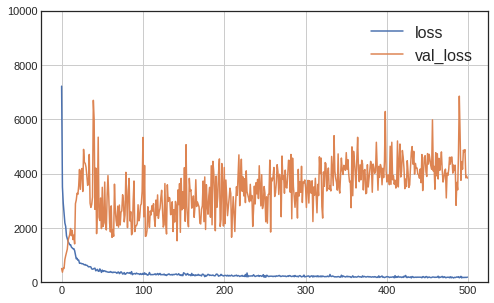

In [56]:
model = BDL_BiLSTM(nunits = nunits, nlayer = nlayer, lr = 0.01, drops = 0.2, batchsize = batchsize, nepochs = nepochs, seq_array = seq_array, label_array = label_array)

In [ ]:
pred_test_id = Pred_test_id(nlayer=nlayer, product_id=4, T=T, model=model, test_dataset=test_dataset,sequence_length=sequence_length, sequence_cols=sequence_cols)

In [63]:
pred_test_id[0]

[14.059096410994966, 580.5197912354234]

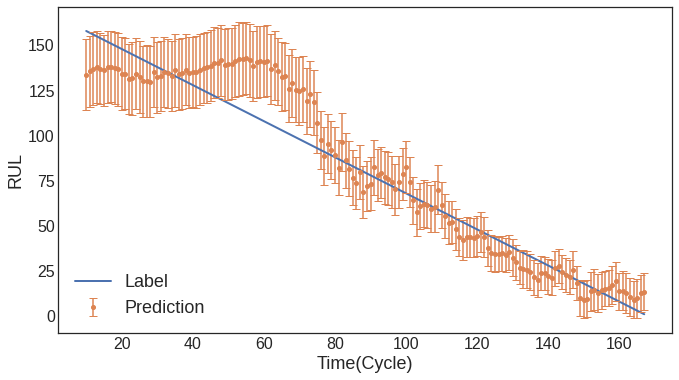

<Figure size 432x288 with 0 Axes>

In [64]:
Plot_unit(pred_mean = pred_test_id[3], pred_std = pred_test_id[4], product_id = 4, test_dataset =  test_dataset, sequence_length = sequence_length)

In [65]:
pd.DataFrame(pred_test_id[1].reshape(T,pred_test_id[1].shape[1])).to_csv("Output/RW18_RUL.csv")

## 维修策略

In [66]:
num1 = 500
cp = 100 # 预测性维修成本
cc = 500 # 修正性维修成本
cf = 5  # 剩余使用价值浪费造成的成本
cos = 10 # 没有库存而进行维修造成的成本
cq = 0.1 # 库存成本
L = 20 #预定时间

In [ ]:
pred_test_id[1].shape

In [141]:
# 维修策略
def static_PdM_cost(current_time, K, dat,cp, cc, cf, cos , cq, L,sequence_length):
  m_re_all = [0,0,0,0]
  future_time = dat.shape[1] + K #这里的40也要进行变化
  rul_time = dat[:,current_time] 
  for i in range(current_time,future_time):
    DT = i - current_time
    DN = ((cc + cos) * np.mean(rul_time <= (DT+1)))/(i+1)
    R = (cp + cf * np.mean(rul_time > DT))/i
    # DN = (((cc + cos * delta[i+1] + (1 - delta[i])*cq)) * np.mean(rul_time <= (DT+1))) #/(i+1)
    # R = (cp + cos * delta[i] + cf * np.mean(rul_time > DT)) #/i
    m_re_all = np.vstack((m_re_all,[i,DN,R,np.mean(rul_time <= DT)]))
    if R >= DN:
      t_best = i # DN的最后一个时间，+1就是R的时间
  m_re_all = m_re_all[1:] # 对应变量的新指标
  m_re_all = pd.DataFrame(m_re_all,columns=['Cycle', 'DN', 'R','CDF'])
  m_re_all['R or DN'] = np.where((m_re_all['DN'] < m_re_all['R'])*1 == 1,"DN","R")
  t_best = t_best + 1
  t_order = t_best - L
  t_best 
  return [t_best + sequence_length, t_order +sequence_length], m_re_all, rul_time
  

In [171]:
def dynamic_PdM_constraint_cost(current_time, scheme, cp, cc, cf, cos, cq, L, K, y_pred):
  # 带约束的PdM框架
  const_alpha = const_beta = []
  optimal_time = [0,0,0]
  for j in range(current_time,y_pred.shape[1]):
    # 假设成本会随时间变化
    static_pdm = static_PdM_cost(current_time = j, K = K, dat = y_pred,sequence_length = sequence_length,
                            cp = cp, cc = cc, cf = cf, cos = cos, cq = cq, L = L)
    t_tentative_best = static_pdm[0][0]
    rul_time = y_pred[:,j] 
    # 加入约束条件，求 T^*_m，T^*_o。
    if t_tentative_best > scheme[0] and t_tentative_best < scheme[1]: #在不能维修的时间框内/这里跟论文中的相反
      DT1 = scheme[0] - j 
      DT2 = scheme[1] - j 
      const_alpha = [(cp + cf * np.mean(rul_time > DT1))/ scheme[0],((cc + cos) * np.mean(rul_time <= (scheme[1])))/(scheme[1])] #计算ta的成本率
      const_beta = [(cp + cf * np.mean(rul_time > DT2))/ scheme[1],((cc + cos) * np.mean(rul_time <= (scheme[1]+1)))/(scheme[1]+1)] #计算tb的成本率
      t_best = np.where(const_alpha.index(min(const_alpha)) == 0,scheme[0],scheme[1]) #选择最优时间
      t_order = t_best - L
    else:   
      t_best = t_tentative_best
      t_order = t_best - L
    optimal_time = np.vstack((optimal_time,[j + sequence_length,t_best,t_order]))
  optimal_time = optimal_time[1:]
  optimal_time = pd.DataFrame(optimal_time,columns=['Cycle', 'T_m','T_o']) #, 'T_o'
  optimal_time['T_o'][0] = optimal_time['T_m'][0] - L
  optimal_time['T_o'][1] = np.floor(np.mean(optimal_time['T_m'][0:2]) - L)
  optimal_time['T_o'][2:] = np.floor([np.mean(optimal_time['T_m'][i-2:(i+1)]) - L for i in range(2,(pred_test_id[1].shape[1] - current_time))])
  
  return optimal_time

In [121]:
sta_PdM = static_PdM_cost(current_time = 110, K = 30, dat = pred_test_id[1], sequence_length =  sequence_length,
                        cp = cp, cc = cc, cf = cf, cos = cos, cq = cq, L = L)

In [122]:
sta_PdM[0]

[161, 141]

In [125]:
sta_PdM[1]

,Cycle,DN,R,CDF,R or DN
0,110.0,0.000000,0.954545,0.0,DN
1,111.0,0.000000,0.945946,0.0,DN
2,112.0,0.000000,0.937500,0.0,DN
3,113.0,0.000000,0.929204,0.0,DN
4,114.0,0.000000,0.921053,0.0,DN
...,...,...,...,...,...
73,183.0,2.771739,0.546448,1.0,R
74,184.0,2.756757,0.543478,1.0,R
75,185.0,2.741935,0.540541,1.0,R
76,186.0,2.727273,0.537634,1.0,R


In [173]:
Scenario1 = dynamic_PdM_constraint_cost(current_time = 110, scheme = [1,2], L = 20, K = 40, y_pred = pred_test_id[1],
                                        cp = cp, cc = cc, cf = cf, cos = cos, cq = cq) #Scenario 1
Scenario1

,Cycle,T_m,T_o
0,120,161,141.0
1,121,164,142.0
2,122,162,142.0
3,123,158,141.0
4,124,156,138.0
5,125,157,137.0
6,126,158,137.0
7,127,159,138.0
8,128,160,139.0
9,129,162,140.0


In [174]:
Scenario2 = dynamic_PdM_constraint_cost(current_time = 110, scheme = [160,170], L = 20, K = 40, y_pred = pred_test_id[1],
                                        cp = cp, cc = cc, cf = cf, cos = cos, cq = cq) #Scenario 1
Scenario2

,Cycle,T_m,T_o
0,120,160,140.0
1,121,160,140.0
2,122,160,140.0
3,123,158,139.0
4,124,156,138.0
5,125,157,137.0
6,126,158,137.0
7,127,159,138.0
8,128,160,139.0
9,129,160,139.0


In [175]:
Scenario3 = dynamic_PdM_constraint_cost(current_time = 110, scheme = [160,170], L = 20, K = 40, y_pred = pred_test_id[1],
                                        cp = cp, cc = cc, cf = cf, cos = cos, cq = cq) #Scenario 1
Scenario3

,Cycle,T_m,T_o
0,120,160,140.0
1,121,160,140.0
2,122,160,140.0
3,123,158,139.0
4,124,156,138.0
5,125,157,137.0
6,126,158,137.0
7,127,159,138.0
8,128,160,139.0
9,129,160,139.0


In [178]:
result = pd.concat([Scenario1, Scenario2[['T_m','T_o']], Scenario3[['T_m','T_o']]], axis=1, join='inner')
#result.to_csv("Output/Table2.csv") # 表4
result

### 性能评比

In [179]:
def fff(product_id,pred_test_id, const,T,cp,cos,cq,cf,cc,L,interval,real_cycle,sequence_length):
    start_t = pred_test_id[1].shape[1] - interval
    end_t = pred_test_id[1].shape[1]
    optimal_time = [[0, 0, 0]]
    constriant = [0]
    opt_order = ten_main = opt_main = [0]
    K = 40
    for j in range(start_t, end_t):
        m_re_all = [0, 0, 0, 0]
        s0 = np.repeat(0, pred_test_id[1].shape[1])
        delta = np.repeat(1, pred_test_id[1].shape[1])
        future_time = pred_test_id[1].shape[1] + K  # 这里的40也要进行变化
        rul_time = pred_test_id[1][:, j]
        for i in range(j + 1, future_time):
            # j时刻，未来各点的DN和R成本比较 公式7，8
            DT = i - j
            CFP = np.mean([rul_time[h] <= DT for h in range(0, T)])
            DN = np.sum([(cc + cos) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (j + r) for r in
                         range(0, DT + 1)])
            R = np.sum([(cc + cos) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (j + r) for r in
                        range(0, DT)]) + np.sum(
                [np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) * (cp + cf * (r - DT) * 1) / (j + DT) for r
                 in range(DT + 1, DT + K)])
            m_re_all = np.vstack((m_re_all, [i, CFP, DN, R]))

        m_re_all = m_re_all[1:]
        t_best = m_re_all[np.where(m_re_all[:, 2] >= m_re_all[:, 3])[0][0], 0]  # 给出没有限制的最优维修时间（t_m） 公式9

        # 加入维修约束 公式10
        if any(t_best == const):  # 在维修窗口/点上，直接维修
            t_best1 = t_best
        else:  # 不再维修窗口上，计算边际点成本率
            cats = np.digitize(t_best, const)
            scheme = const[(cats - 1):(cats + 1)]
            constriant = pd.DataFrame([[np.sum(
                [(cc + cos) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (j + r) for r in
                 range(0, scheme[1] - j)]), np.sum(
                [(cc + cos) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (j + r) for r in
                 range(0, scheme[0] - j)]) + np.sum(
                [np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) * (cp + cf * (r - DT) * 1) / (j + DT) for r
                 in range(scheme[0] - j + 1, scheme[0] - j + K)])],
                                       [np.sum([(cc + cos) * np.mean(
                                           [r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (j + r) for r in
                                                range(0, scheme[1] - j + 1)]), np.sum([(cc + cos) * np.mean(
                                           [r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (j + r) for r in
                                                                                       range(0,scheme[1] - j)]) + np.sum([
                                                                                                                           np.mean(
                                                                                                                               [
                                                                                                                                   r <=
                                                                                                                                   rul_time[
                                                                                                                                       h] < (
                                                                                                                                               r + 1)
                                                                                                                                   for
                                                                                                                                   h
                                                                                                                                   in
                                                                                                                                   range(
                                                                                                                                       0,
                                                                                                                                       T)]) * (
                                                                                                                                       cp + cf * (
                                                                                                                                           r - DT) * 1) / (
                                                                                                                                       j + DT)
                                                                                                                           for
                                                                                                                           r
                                                                                                                           in
                                                                                                                           range(
                                                                                                                               scheme[
                                                                                                                                   1] - j + 1,
                                                                                                                               scheme[
                                                                                                                                   1] - j + K)])]])
            t_best1 = scheme[np.where(m_re_all[:, 0] >= m_re_all[:, 2])[0][0]]

        # 当前时刻最优预定时间 公式11
        if np.size(optimal_time, 0) == 1:
            t_order1 = t_best1 - L
        else:
            t_order1 = np.floor(np.mean(pd.concat([pd.Series(optimal_time[1:, 1]), pd.Series(t_best1)]))) - L  # order优化

        optimal_time = np.vstack((optimal_time, [j, t_best1, t_order1]))  # 表3

        # 选择真正的预定时间点 公式12
        if optimal_time[-1:, 0] >= optimal_time[-1:, 2] and opt_order == [0]:
            opt_order = optimal_time[-1:, 0]
            opt_order = opt_order[0]

        # 调整真正的维修时间点 公式14,15,18
        if opt_order != [0]:
            if optimal_time[-1:, 0] < optimal_time[-1:, 1] and optimal_time[-1:, 0] == (opt_order + L):  # 第一种情况 b>a
                a = optimal_time[-1:, 0][0].astype(int)  # / opt_order + L
                b = optimal_time[-1:, 1][0].astype(int)
                count = np.arange(a, b + 1, 1)
                cou1 = np.array([any(i == const) for i in count])  # 提取出在维修窗口的点
                ten_main = b
                # 计算公式14 / 文中h=代码r,j不变
                re = [np.sum(
                    [(cc + cq * r) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (a + r) for r in
                     range(0, j)])
                      + np.sum(
                    [np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) * (cp + cf * (r - j) + cq * j) / (a + j)
                     for r in range(j + 1, j + K)]) for j in range(0, b - a + 1)]
                opt_main = a + np.argwhere(re == np.min(np.array(re)[cou1]))  # 最优时间点
                opt_main = opt_main[0, 0]
                print("case 1")
                break
            if optimal_time[-1:, 0] >= optimal_time[-1:, 1] and optimal_time[-1:, 0] < (opt_order + L):  # 第二种情况 b<a
                a = optimal_time[-1:, 0][0].astype(int)  # / opt_order + L
                b = optimal_time[-1:, 1][0].astype(int)
                count = np.arange(b, a + 1, 1)
                cou1 = np.array([any(i == const) for i in count])  # 提取出在维修窗口的点
                # 计算公式15
                re1 = [np.sum(
                    [(cc + cos) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (b + r) for r in
                     range(0, j)]) + np.sum(
                    [np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) * (cp + cf * (r - j) + cos) / (b + j)
                     for r in range(j + 1, j + K)]) for j in range(0, a - b)]  # 最后一项a需要另外算
                C_b_a = np.sum(
                    [(cc + cos) * np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) / (b + r) for r in
                     range(0, a - b)]) + np.sum(
                    [np.mean([r <= rul_time[h] < (r + 1) for h in range(0, T)]) * (cp + cf * (r - a + b)) / (a) for r in
                     range(a - b + 1, a - b + K)])
                re1.append(C_b_a)
                opt_main = b + np.argwhere(re1 == np.min(np.array(re1)[cou1]))  # 最优时间点
                opt_main = opt_main[0, 0]
                print("case 2")
                ten_main = optimal_time[-1:, 1][0]
                break
            if optimal_time[-1:, 0] >= optimal_time[-1:, 1] and optimal_time[-1:, 0] == (opt_order + L):  # 第三种情况 b=a
                # 计算公式18
                opt_main = optimal_time[-1:, 0][0].astype(int)
                ten_main = opt_main.astype(int)
                print("case 3")
                break
    # 找到公式 17 中的 sum(h*p_h|psi)/psi为最优维修点
    #if np.array(opt_main) < real_cycle[product_id] - 25 and np.array(opt_main) != [0] and np.array(opt_main) != [25]:
    #    psi = np.floor(np.sum([np.mean([r <= pred_test_id[1][:, opt_main][h] < (r + 1) for h in range(0, T)]) * r for r in range(0, 300)]))
    #else:
    #    psi = 0
    psi = 0
    # Table 3
    optimal_time = pd.DataFrame(optimal_time[1:], columns=['Cycle', 'T_m', 'T_o'])
    return [optimal_time + sequence_length], [product_id, opt_order + sequence_length, np.array(ten_main) + sequence_length, np.array(opt_main) + sequence_length,
                                 real_cycle[product_id], psi]


In [180]:
def case_choice(case,sequence_length):
    # 剪掉25的，记得加回去
    const = []
    # 检测1
    if case == 1:
        const = np.arange(0, 400, 1) - sequence_length
        # 检测2
    elif case == 2:
        const = np.asarray([np.arange(10 + 20 * i, 21 + 20 * i, 1) for i in range(0, 20)]) - sequence_length
        const = const.flatten()
    # 检测3
    else:
        const = np.arange(10, 360, 10) - sequence_length
    return const

In [ ]:
#pred_test_id = Pred_test_id(nlayer=nlayer, product_id = 4, T=T, model=model, test_dataset=test_dataset,sequence_length=sequence_length, sequence_cols=sequence_cols)

In [ ]:
#Plot_unit(pred_mean = pred_test_id[3], pred_std = pred_test_id[4], product_id = 4, test_dataset =  test_dataset, sequence_length = sequence_length)

In [ ]:
case_choice(case=2,sequence_length=sequence_length)

In [185]:
re1 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=1,sequence_length=sequence_length),
          T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc,L=20,interval = 50,real_cycle = [0,168,168,168,168],sequence_length=sequence_length)

case 1


In [107]:
re2 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=2,sequence_length=sequence_length),
          T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc,L=20,interval = 40,real_cycle = [0,168,168,168,168],sequence_length=sequence_length)

case 1


In [108]:
re3 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=3,sequence_length=sequence_length),
          T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc,L=20,interval = 30,real_cycle = [0,168,168,168,168],sequence_length=sequence_length)

case 2


In [187]:
pd.DataFrame(np.vstack((re1[1],re2[1], re3[1])), columns=['id', 'O*', 'M', 'M*', 'f', 'psi'])

,id,O*,M,M*,f,psi
0,4.0,140.0,173.0,168.0,168.0,0.0
1,4.0,138.0,174.0,170.0,168.0,0.0
2,4.0,140.0,150.0,150.0,168.0,0.0


In [186]:
re1[0]

[    Cycle    T_m    T_o
 0   118.0  161.0  141.0
 1   119.0  162.0  141.0
 2   120.0  164.0  142.0
 3   121.0  168.0  143.0
 4   122.0  166.0  144.0
 5   123.0  159.0  143.0
 6   124.0  158.0  142.0
 7   125.0  158.0  142.0
 8   126.0  159.0  141.0
 9   127.0  160.0  141.0
 10  128.0  160.0  141.0
 11  129.0  163.0  141.0
 12  130.0  162.0  141.0
 13  131.0  160.0  141.0
 14  132.0  157.0  141.0
 15  133.0  159.0  141.0
 16  134.0  159.0  140.0
 17  135.0  158.0  140.0
 18  136.0  156.0  140.0
 19  137.0  156.0  140.0
 20  138.0  161.0  140.0
 21  139.0  161.0  140.0
 22  140.0  161.0  140.0
 23  141.0  161.0  140.0
 24  142.0  167.0  140.0
 25  143.0  170.0  141.0
 26  144.0  167.0  141.0
 27  145.0  166.0  141.0
 28  146.0  166.0  141.0
 29  147.0  172.0  141.0
 30  148.0  165.0  142.0
 31  149.0  158.0  141.0
 32  150.0  158.0  141.0
 33  151.0  160.0  141.0
 34  152.0  165.0  141.0
 35  153.0  169.0  142.0
 36  154.0  166.0  142.0
 37  155.0  167.0  142.0
 38  156.0  169.0  142.0


In [184]:
re2[0]

[    Cycle    T_m    T_o
 0   128.0  160.0  140.0
 1   129.0  160.0  140.0
 2   130.0  160.0  140.0
 3   131.0  160.0  140.0
 4   132.0  157.0  139.0
 5   133.0  159.0  139.0
 6   134.0  159.0  139.0
 7   135.0  158.0  139.0
 8   136.0  156.0  138.0
 9   137.0  156.0  138.0
 10  138.0  160.0  138.0
 11  139.0  160.0  138.0
 12  140.0  160.0  138.0
 13  141.0  160.0  138.0
 14  142.0  160.0  139.0
 15  143.0  170.0  139.0
 16  144.0  160.0  139.0
 17  145.0  160.0  139.0
 18  146.0  160.0  139.0
 19  147.0  172.0  140.0
 20  148.0  160.0  140.0
 21  149.0  158.0  140.0
 22  150.0  158.0  140.0
 23  151.0  160.0  140.0
 24  152.0  160.0  140.0
 25  153.0  160.0  140.0
 26  154.0  160.0  140.0
 27  155.0  160.0  140.0
 28  156.0  160.0  140.0
 29  157.0  171.0  140.0
 30  158.0  174.0  140.0]

In [ ]:
re3[0] # 三者凑表2

[    Cycle    T_m    T_o
 0   138.0  150.0  130.0
 1   139.0  150.0  130.0
 2   140.0  150.0  130.0
 3   141.0  160.0  132.0
 4   142.0  160.0  134.0
 5   143.0  160.0  135.0
 6   144.0  160.0  135.0
 7   145.0  160.0  136.0
 8   146.0  160.0  136.0
 9   147.0  160.0  137.0
 10  148.0  160.0  137.0
 11  149.0  160.0  137.0
 12  150.0  150.0  136.0]

### 性能评估

In [ ]:
writer = pd.ExcelWriter("Output/sensitive_analysis.xlsx") # 75min

In [ ]:
pred_test_id = Pred_test_id(nlayer=nlayer, product_id=4, T=T, model=model, test_dataset=test_dataset,
                              sequence_length=sequence_length, sequence_cols=sequence_cols)

In [26]:
def sensitive_analysis(scenario = 1,pred_test_id = pred_test_id):
  cc1 = [1.1,1.5,2,5,8,10]
  each_engine_re1 = [0, 0, 0, 0, 0, 0]
  each_engine_re2 = [0, 0, 0, 0, 0, 0]
  each_engine_re3 = [0, 0, 0, 0, 0, 0]
  real_cycle = [0,124,108,167,168]

  #画图
  #Plot_unit(pred_mean = pred_test_id[3], pred_std = pred_test_id[4], product_id = 4, test_dataset =  test_dataset, sequence_length = sequence_length)
  T1 = time.time()
  re1 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=1,sequence_length=sequence_length),
          T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc1[scenario]*cp,L=20,interval = 50,real_cycle = real_cycle,sequence_length=sequence_length)
  re2 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=2,sequence_length=sequence_length),
          T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc1[scenario]*cp,L=20,interval = 40,real_cycle = real_cycle,sequence_length=sequence_length)
  re3 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=3,sequence_length=sequence_length),
          T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc1[scenario]*cp,L=20,interval = 30,real_cycle = real_cycle,sequence_length=sequence_length)
  print(time.time() - T1)
  sensitive_re = pd.concat([pd.DataFrame(re1[1]).T,pd.DataFrame(re2[1]).T,pd.DataFrame(re3[1]).T], axis=0)
  return sensitive_re

In [ ]:
cc1 = [1.1,1.5,2,5,8,10]
each_engine_re1 = [0, 0, 0, 0, 0, 0]
each_engine_re2 = [0, 0, 0, 0, 0, 0]
each_engine_re3 = [0, 0, 0, 0, 0, 0]
real_cycle = [0,124,108,167,168]

pred_test_id = Pred_test_id(nlayer=nlayer, product_id=4, T=T, model=model, test_dataset=test_dataset,
                            sequence_length=sequence_length, sequence_cols=sequence_cols)
#画图
Plot_unit(pred_mean = pred_test_id[3], pred_std = pred_test_id[4], product_id = 4, test_dataset =  test_dataset, sequence_length = sequence_length)


In [ ]:
T1 = time.time()
re1 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=1,sequence_length=sequence_length),
        T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc1[scenario]*cp,L=20,interval = 50,real_cycle = real_cycle,sequence_length=sequence_length)
re2 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=2,sequence_length=sequence_length),
        T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc1[scenario]*cp,L=20,interval = 40,real_cycle = real_cycle,sequence_length=sequence_length)
re3 = fff(product_id = 4,pred_test_id=pred_test_id, const=case_choice(case=3,sequence_length=sequence_length),
        T=T,cp=cp,cos=cos,cq=cq,cf=cf,cc=cc1[scenario]*cp,L=20,interval = 30,real_cycle = real_cycle,sequence_length=sequence_length)
print(time.time() - T1)
sensitive_re = pd.concat([pd.DataFrame(re1[1]).T,pd.DataFrame(re2[1]).T,pd.DataFrame(re3[1]).T], axis=0)
sensitive_re

In [ ]:
senti1 = sensitive_analysis(scenario = 0,pred_test_id = pred_test_id)

In [27]:
# 计算表5结果（只看unit81）
senti1 = sensitive_analysis(scenario = 0,pred_test_id = pred_test_id)
senti2 = sensitive_analysis(scenario = 1,pred_test_id = pred_test_id)
senti3 = sensitive_analysis(scenario = 2,pred_test_id = pred_test_id)
senti4 = sensitive_analysis(scenario = 3,pred_test_id = pred_test_id)
senti5 = sensitive_analysis(scenario = 4,pred_test_id = pred_test_id)
senti6 = sensitive_analysis(scenario = 5,pred_test_id = pred_test_id)

se_all = se1.append([senti2,senti3,senti4,senti5,senti6])
se_all.to_csv('Output/senstive_RW18.csv')

case 1
case 1
case 1
1190.3327946662903
case 1
case 1
case 1
1175.9287037849426
case 1
case 1
case 1
1160.5335130691528
case 1
case 1
case 1
1070.7067992687225
case 1
case 1
case 1
1060.444932937622
case 1
case 1
case 1
1046.1913335323334


In [188]:
se1

NameError: ignored

In [28]:
se_all

,0,1,2,3,4,5
0,4.0,134.0,168.0,167.0,168.0,0.0
0,4.0,132.0,160.0,160.0,168.0,0.0
0,4.0,138.0,170.0,170.0,168.0,0.0
0,4.0,132.0,166.0,163.0,168.0,0.0
0,4.0,132.0,160.0,160.0,168.0,0.0
0,4.0,138.0,170.0,170.0,168.0,0.0
0,4.0,131.0,165.0,162.0,168.0,0.0
0,4.0,132.0,160.0,160.0,168.0,0.0
0,4.0,138.0,170.0,170.0,168.0,0.0
0,4.0,125.0,163.0,162.0,168.0,0.0
